# Séance 4 — Vision Transformers (ViT) : de la théorie à la visualisation

---

## Objectifs

1. Comprendre le pipeline ViT : **patchify → embedding → Transformer Encoder → classification**.
2. Charger un ViT pré-entraîné et l’utiliser pour la **classification d’images**.
3. **Visualiser les cartes d’attention** pour comprendre ce que le modèle "regarde".
4. Comparer les attentions de **différentes têtes** et **différentes couches**.
5. Explorer le **CLS token** et les **position embeddings**.

---

## Plan

1. Setup et chargement du modèle
2. Pipeline ViT pas à pas
3. Classification d’une image
4. Extraction et visualisation des cartes d’attention
5. Analyse multi-têtes / multi-couches
6. Visualisation des position embeddings
7. Exercices

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cv2
from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## 1. Chargement du modèle ViT pré-entraîné

On utilise `vit_base_patch16_224` de la bibliothèque **timm** (PyTorch Image Models).

- **ViT-Base** : 12 blocs Transformer, dimension D=768, 12 têtes d’attention
- **Patch 16** : patches de 16×16 pixels
- **224** : images d’entrée 224×224
- Pré-entraîné sur **ImageNet-21k**, fine-tuné sur **ImageNet-1k** (1000 classes)

In [6]:
!pip install timm 
# si pas installé
import timm

model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True)
model = model.to(device)
model.eval()

print(f'Mod\u00e8le : {model_name}')
print(f'Nombre de param\u00e8tres : {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M')
print(f'Nombre de blocs : {len(model.blocks)}')
print(f'Dimension embedding D : {model.embed_dim}')
print(f'Nombre de t\u00eates : {model.blocks[0].attn.num_heads}')
print(f'Taille patch : {model.patch_embed.patch_size}')

  Using cached timm-1.0.24-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached typer_slim-0.23.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached typer-0.23.1-py3-none-any.whl.metadata (16 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached rich-14.3.2-py3-none-any.whl.metadata (18 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached timm-1.0.24-py3-none-any.whl (2.6 MB)
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)
Using cached safetensors

f:\Pro\ObsidianPro\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
f:\Pro\ObsidianPro\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tomsa\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate 

Modèle : vit_base_patch16_224
Nombre de paramètres : 86.6M
Nombre de blocs : 12
Dimension embedding D : 768
Nombre de têtes : 12
Taille patch : (16, 16)


## 2. Pipeline ViT pas à pas

Rappel du pipeline :

```
Image (224×224×3)
   ↓
Patchify (14×14 = 196 patches de 16×16)
   ↓
Patch Embedding (projection linéaire → 196 vecteurs de dim 768)
   ↓
Ajout [CLS] token → 197 tokens
   ↓
Ajout Position Embeddings
   ↓
12 blocs Transformer Encoder
   ↓
Tête de classification (sur [CLS]) → 1000 classes
```

### 2.1 Charger et prétraiter une image

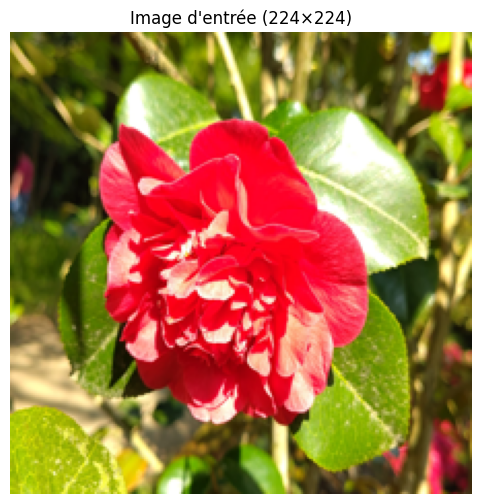

Tensor shape : torch.Size([1, 3, 224, 224])  (B, C, H, W)


In [7]:
# Charger une image locale
IMAGE_PATH = r'../Vision Transformer/exempleCours.jpeg'
img_pil = Image.open(IMAGE_PATH).convert('RGB')

# Prétraitement standard ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

img_tensor = transform(img_pil).unsqueeze(0).to(device)  # (1, 3, 224, 224)

# Afficher l'image originale
plt.figure(figsize=(6, 6))
plt.imshow(img_pil.resize((224, 224)))
plt.title('Image d\'entrée (224×224)')
plt.axis('off')
plt.show()

print(f'Tensor shape : {img_tensor.shape}  (B, C, H, W)')

### 2.2 Visualiser les patches

On découpe l’image en patches 16×16 pour voir ce que le modèle reçoit comme "tokens".

C:\Users\tomsa\AppData\Local\Temp\ipykernel_8188\3044533743.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


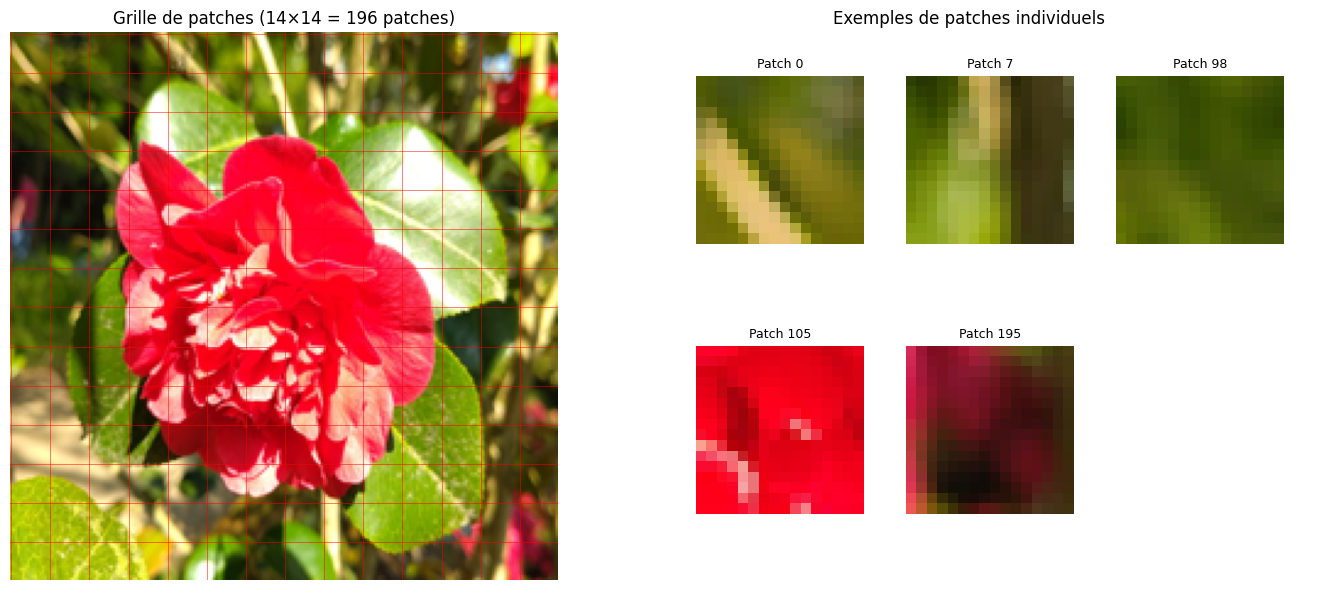

In [8]:
def show_patches(img_pil, patch_size=16):
    """Affiche l'image avec la grille de patches superpos\u00e9e."""
    img_resized = img_pil.resize((224, 224))
    img_np = np.array(img_resized)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Image avec grille
    axes[0].imshow(img_np)
    for i in range(0, 224, patch_size):
        axes[0].axhline(y=i, color='red', linewidth=0.5, alpha=0.7)
        axes[0].axvline(x=i, color='red', linewidth=0.5, alpha=0.7)
    n_patches = (224 // patch_size) ** 2
    axes[0].set_title(f'Grille de patches ({224//patch_size}\u00d7{224//patch_size} = {n_patches} patches)')
    axes[0].axis('off')
    
    # Quelques patches individuels
    grid_size = 224 // patch_size  # 14
    sample_indices = [0, 7, 98, 105, 195]  # coins + centre + dernier
    axes[1].set_title('Exemples de patches individuels')
    axes[1].axis('off')
    
    for idx, patch_idx in enumerate(sample_indices):
        row = patch_idx // grid_size
        col = patch_idx % grid_size
        patch = img_np[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size]
        ax_inset = fig.add_axes([0.55 + (idx % 3) * 0.15, 0.55 - (idx // 3) * 0.45, 0.12, 0.35])
        ax_inset.imshow(patch)
        ax_inset.set_title(f'Patch {patch_idx}', fontsize=9)
        ax_inset.axis('off')
    
    plt.tight_layout()
    plt.show()

show_patches(img_pil)

### 2.3 Patch Embedding : de l’image aux tokens

Le `patch_embed` du modèle transforme l’image en une séquence de vecteurs.

In [9]:
with torch.no_grad():
    # Patch embedding (convolution kernel=16, stride=16)
    patch_embeddings = model.patch_embed(img_tensor)
    print(f'Apr\u00e8s patch_embed : {patch_embeddings.shape}  (B, N, D)')
    print(f'  N = {patch_embeddings.shape[1]} patches')
    print(f'  D = {patch_embeddings.shape[2]} dimension embedding')
    
    # Ajout du CLS token
    cls_token = model.cls_token.expand(1, -1, -1)
    tokens = torch.cat([cls_token, patch_embeddings], dim=1)
    print(f'\nApr\u00e8s ajout [CLS] : {tokens.shape}  (B, N+1, D)')
    
    # Ajout des position embeddings
    tokens_with_pos = tokens + model.pos_embed
    print(f'Apr\u00e8s position embeddings : {tokens_with_pos.shape}  (B, N+1, D)')
    print(f'\nPos embed shape : {model.pos_embed.shape}  (1, N+1, D)')

Après patch_embed : torch.Size([1, 196, 768])  (B, N, D)
  N = 196 patches
  D = 768 dimension embedding

Après ajout [CLS] : torch.Size([1, 197, 768])  (B, N+1, D)
Après position embeddings : torch.Size([1, 197, 768])  (B, N+1, D)

Pos embed shape : torch.Size([1, 197, 768])  (1, N+1, D)


## 3. Classification d’une image

On utilise le modèle complet pour classifier l’image et afficher le top-5 des prédictions.

Classes "fleur" trouvées dans ImageNet (17) :
  [ 28] spotted salamander
  [170] Irish Wolfhound
  [184] Irish Terrier
  [213] Irish Setter
  [221] Irish Water Spaniel
  [344] hippopotamus
  [521] Crock Pot
  [738] pot
  [739] potter's wheel
  [818] spotlight
  [849] teapot
  [926] hot pot
  [935] mashed potato
  [938] cauliflower
  [964] pot pie
  [985] daisy
  [989] rose hip

Top-5 prédictions GLOBALES :
--------------------------------------------------
  1. pomegranate                    (45.2%)
  2. bee                            (29.5%)
  3. earth star                     (2.0%)
  4. split-rail fence               (1.8%)
  5. fig                            (1.7%)

Top-5 prédictions FLEURS uniquement :
--------------------------------------------------
  1. daisy                          (1.03%)
  2. pot                            (0.84%)
  3. rose hip                       (0.46%)
  4. hot pot                        (0.02%)
  5. pot pie                        (0.01%)


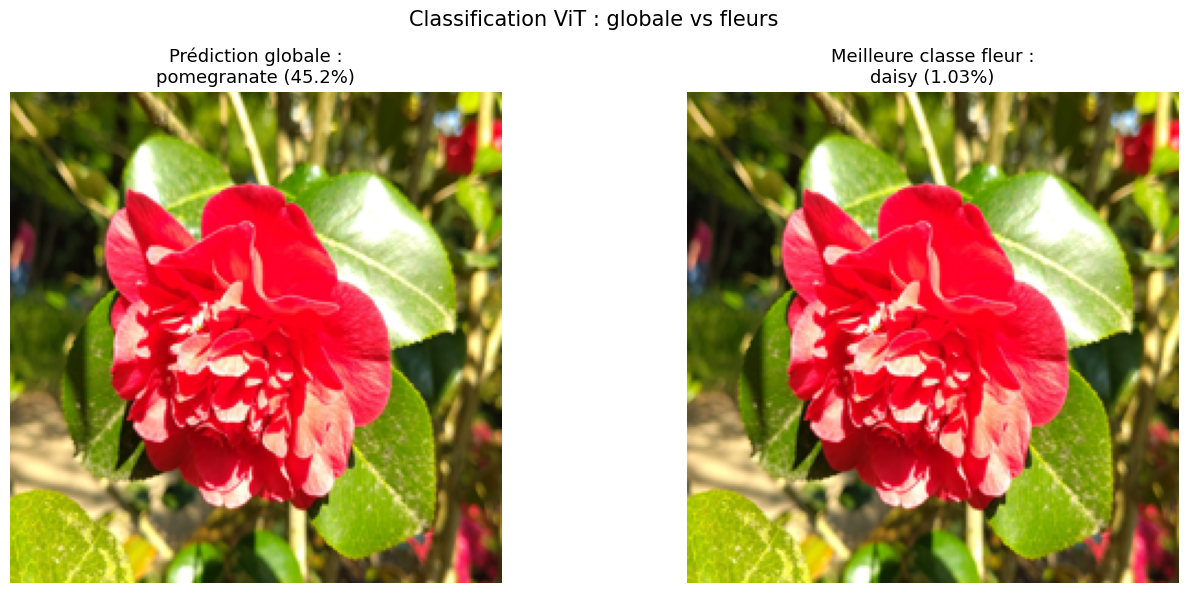

In [11]:
# Classification adaptée aux fleurs
# On utilise le modèle ViT (ImageNet) et on filtre les classes de fleurs
import json

# Charger les labels ImageNet complets
IMAGENET_LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = json.loads(requests.get(IMAGENET_LABELS_URL).text)

# Identifier toutes les classes "fleur" dans ImageNet
flower_keywords = ['daisy', 'rose', 'tulip', 'sunflower', 'dandelion', 'lily',
                   'orchid', 'iris', 'poppy', 'lotus', 'hibiscus', 'flower',
                   'bouquet', 'pot', 'bee orchid', 'buttercup', 'chamomile',
                   'columbine', 'corn poppy', 'foxglove', 'fritillary',
                   'globe flower', 'grape hyacinth', 'hippeastrum', 'japanese anemone',
                   'lenten rose', 'petunia', 'pincushion flower', 'primula',
                   'prince of wales feathers', 'rose', 'sweet pea', 'wallflower']
flower_indices = [i for i, l in enumerate(labels)
                  if any(kw in l.lower() for kw in flower_keywords)]

print(f'Classes "fleur" trouvées dans ImageNet ({len(flower_indices)}) :')
for idx in flower_indices:
    print(f'  [{idx:3d}] {labels[idx]}')

# Classification
with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=-1)

    # Top-5 global
    top5_probs, top5_indices = probs.topk(5, dim=-1)

    # Top-5 parmi les classes de fleurs uniquement
    flower_probs = probs[0, flower_indices]
    top5_flower_probs, top5_flower_local = flower_probs.topk(min(5, len(flower_indices)))
    top5_flower_indices = [flower_indices[i] for i in top5_flower_local.tolist()]

print('\n' + '=' * 50)
print('Top-5 prédictions GLOBALES :')
print('-' * 50)
for i in range(5):
    idx = top5_indices[0, i].item()
    prob = top5_probs[0, i].item()
    marker = '  <-- fleur' if idx in flower_indices else ''
    print(f'  {i+1}. {labels[idx]:30s} ({prob*100:.1f}%){marker}')

print(f'\nTop-5 prédictions FLEURS uniquement :')
print('-' * 50)
for i in range(min(5, len(flower_indices))):
    idx = top5_flower_indices[i]
    prob = top5_flower_probs[i].item()
    print(f'  {i+1}. {labels[idx]:30s} ({prob*100:.2f}%)')

# Afficher avec la prédiction
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prédiction globale
axes[0].imshow(img_pil.resize((224, 224)))
best_label = labels[top5_indices[0, 0].item()]
best_prob = top5_probs[0, 0].item()
axes[0].set_title(f'Prédiction globale :\n{best_label} ({best_prob*100:.1f}%)', fontsize=13)
axes[0].axis('off')

# Prédiction fleur
axes[1].imshow(img_pil.resize((224, 224)))
best_flower = labels[top5_flower_indices[0]]
best_flower_prob = top5_flower_probs[0].item()
axes[1].set_title(f'Meilleure classe fleur :\n{best_flower} ({best_flower_prob*100:.2f}%)', fontsize=13)
axes[1].axis('off')

plt.suptitle('Classification ViT : globale vs fleurs', fontsize=15)
plt.tight_layout()
plt.show()

## 4. Extraction et visualisation des cartes d’attention

C’est le c\u0153ur de cette séance : on va **extraire les poids d’attention** de chaque couche
pour voir **quels patches le modèle regarde** quand il classifie l’image.

### 4.1 Principe

Dans chaque bloc Transformer, la self-attention calcule :

$$A = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)$$

La matrice `A` a la forme `(num_heads, T, T)` o\u00f9 `T = 197` tokens.

La **ligne 0** de `A` correspond au token `[CLS]` : elle nous dit **\u00e0 quels patches le CLS pr\u00eate attention**.

### 4.2 Hook pour capturer les attentions

In [12]:
# On enregistre un hook sur chaque bloc pour capturer les poids d'attention
attention_maps = []

def get_attention_hook(module, input, output):
    """Hook pour capturer les poids d'attention de chaque bloc."""
    # timm ViT : on peut acc\u00e9der \u00e0 l'attention via forward modifi\u00e9
    attention_maps.append(module.attn_weights)

# M\u00e9thode alternative : forward manuel avec extraction d'attention
def extract_attentions(model, img_tensor):
    """Fait un forward pass et extrait les attentions de toutes les couches."""
    attentions = []
    
    with torch.no_grad():
        # Patch embed + CLS + pos
        x = model.patch_embed(img_tensor)
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + model.pos_embed
        x = model.pos_drop(x)
        
        # Passer par chaque bloc et capturer l'attention
        for blk in model.blocks:
            # LayerNorm
            x_norm = blk.norm1(x)
            
            # Self-Attention manuelle pour capturer A
            B, N, C = x_norm.shape
            qkv = blk.attn.qkv(x_norm).reshape(B, N, 3, blk.attn.num_heads, C // blk.attn.num_heads)
            qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, d_head)
            q, k, v = qkv.unbind(0)
            
            scale = (C // blk.attn.num_heads) ** -0.5
            attn = (q @ k.transpose(-2, -1)) * scale  # (B, heads, N, N)
            attn = attn.softmax(dim=-1)
            attentions.append(attn.cpu())
            
            # Continuer le forward normalement
            attn_out = (attn @ v).transpose(1, 2).reshape(B, N, C)
            attn_out = blk.attn.proj(attn_out)
            attn_out = blk.attn.proj_drop(attn_out)
            x = x + attn_out
            x = x + blk.mlp(blk.norm2(x))
    
    return attentions  # liste de 12 tenseurs (B, heads, N, N)

attentions = extract_attentions(model, img_tensor)
print(f'Nombre de couches : {len(attentions)}')
print(f'Shape par couche : {attentions[0].shape}  (B, heads, T, T)')
print(f'  T = {attentions[0].shape[-1]} tokens (1 CLS + 196 patches)')

Nombre de couches : 12
Shape par couche : torch.Size([1, 12, 197, 197])  (B, heads, T, T)
  T = 197 tokens (1 CLS + 196 patches)


### 4.3 Visualiser l’attention du token [CLS]

Le token `[CLS]` agrège l’information de toute l’image. En regardant **sa ligne dans la matrice d’attention**,
on voit quels patches il juge importants pour la classification.

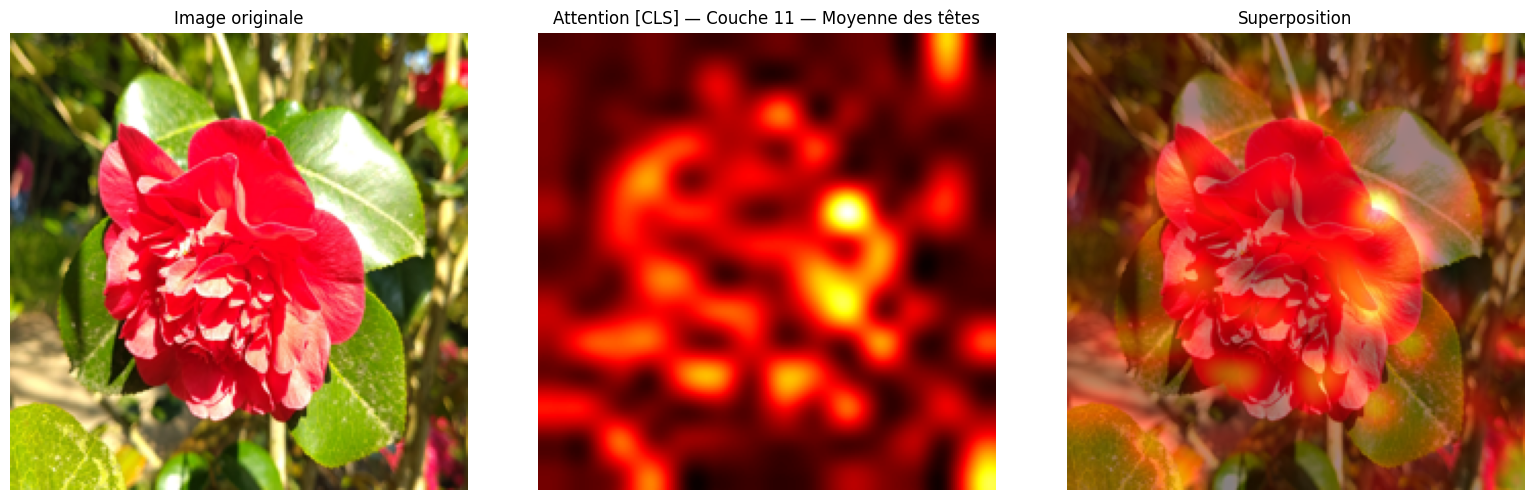

In [13]:
def visualize_cls_attention(attentions, img_pil, layer_idx=-1, head_idx=None):
    """
    Visualise l'attention du token [CLS] sur les patches.
    
    Args:
        attentions: liste de tenseurs (B, heads, T, T)
        img_pil: image PIL originale
        layer_idx: indice de la couche (-1 = derni\u00e8re)
        head_idx: indice de la t\u00eate (None = moyenne sur toutes les t\u00eates)
    """
    attn = attentions[layer_idx][0]  # (heads, T, T)
    
    if head_idx is not None:
        cls_attn = attn[head_idx, 0, 1:]  # attention du CLS vers les patches
        title_suffix = f'T\u00eate {head_idx}'
    else:
        cls_attn = attn[:, 0, 1:].mean(dim=0)  # moyenne sur les t\u00eates
        title_suffix = 'Moyenne des t\u00eates'
    
    # Reshape en grille 14x14
    grid_size = int(cls_attn.shape[0] ** 0.5)  # 14
    cls_attn_map = cls_attn.reshape(grid_size, grid_size).numpy()
    
    # Redimensionner \u00e0 224x224
    attn_resized = cv2.resize(cls_attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())
    
    img_np = np.array(img_pil.resize((224, 224))) / 255.0
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Image originale
    axes[0].imshow(img_np)
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    # Carte d'attention brute
    axes[1].imshow(attn_resized, cmap='hot')
    layer_num = layer_idx if layer_idx >= 0 else len(attentions) + layer_idx
    axes[1].set_title(f'Attention [CLS] \u2014 Couche {layer_num} \u2014 {title_suffix}')
    axes[1].axis('off')
    
    # Superposition
    axes[2].imshow(img_np)
    axes[2].imshow(attn_resized, cmap='hot', alpha=0.5)
    axes[2].set_title('Superposition')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Derni\u00e8re couche, moyenne des t\u00eates
visualize_cls_attention(attentions, img_pil, layer_idx=-1, head_idx=None)

### 4.4 Comparer les couches

Les premières couches capturent des patterns **locaux** (contours, textures),
les dernières couches capturent des relations **globales** (objet entier, contexte).

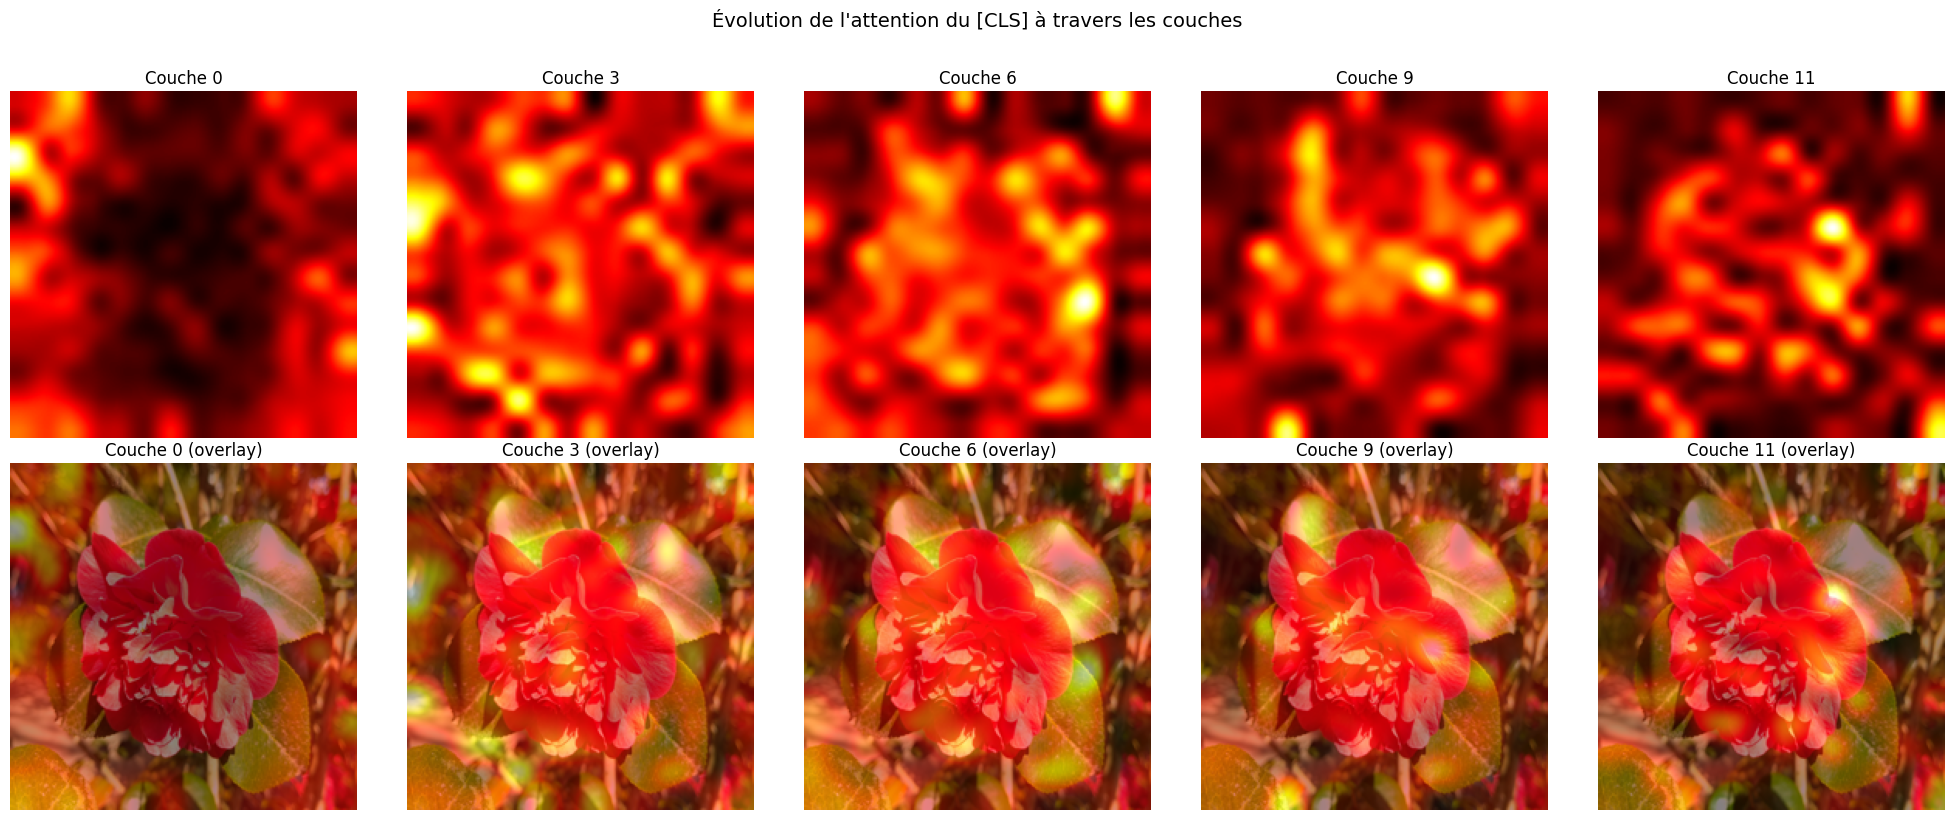

In [14]:
def compare_layers(attentions, img_pil, layers=[0, 3, 6, 9, 11]):
    """Compare l'attention du CLS \u00e0 travers diff\u00e9rentes couches."""
    img_np = np.array(img_pil.resize((224, 224))) / 255.0
    n = len(layers)
    
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))
    
    for col, layer_idx in enumerate(layers):
        attn = attentions[layer_idx][0]  # (heads, T, T)
        cls_attn = attn[:, 0, 1:].mean(dim=0)  # moyenne des t\u00eates
        grid_size = int(cls_attn.shape[0] ** 0.5)
        attn_map = cls_attn.reshape(grid_size, grid_size).numpy()
        attn_resized = cv2.resize(attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
        attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())
        
        # Carte d'attention
        axes[0, col].imshow(attn_resized, cmap='hot')
        axes[0, col].set_title(f'Couche {layer_idx}', fontsize=12)
        axes[0, col].axis('off')
        
        # Superposition
        axes[1, col].imshow(img_np)
        axes[1, col].imshow(attn_resized, cmap='hot', alpha=0.5)
        axes[1, col].set_title(f'Couche {layer_idx} (overlay)', fontsize=12)
        axes[1, col].axis('off')
    
    plt.suptitle('\u00c9volution de l\'attention du [CLS] \u00e0 travers les couches', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

compare_layers(attentions, img_pil)

## 5. Analyse multi-têtes

Chaque tête d’attention apprend à se concentrer sur un **aspect différent** de l’image :
- Certaines têtes regardent les **contours**
- D’autres regardent les **textures**
- D’autres capturent le **contexte global**

### 5.1 Visualiser toutes les têtes d’une couche

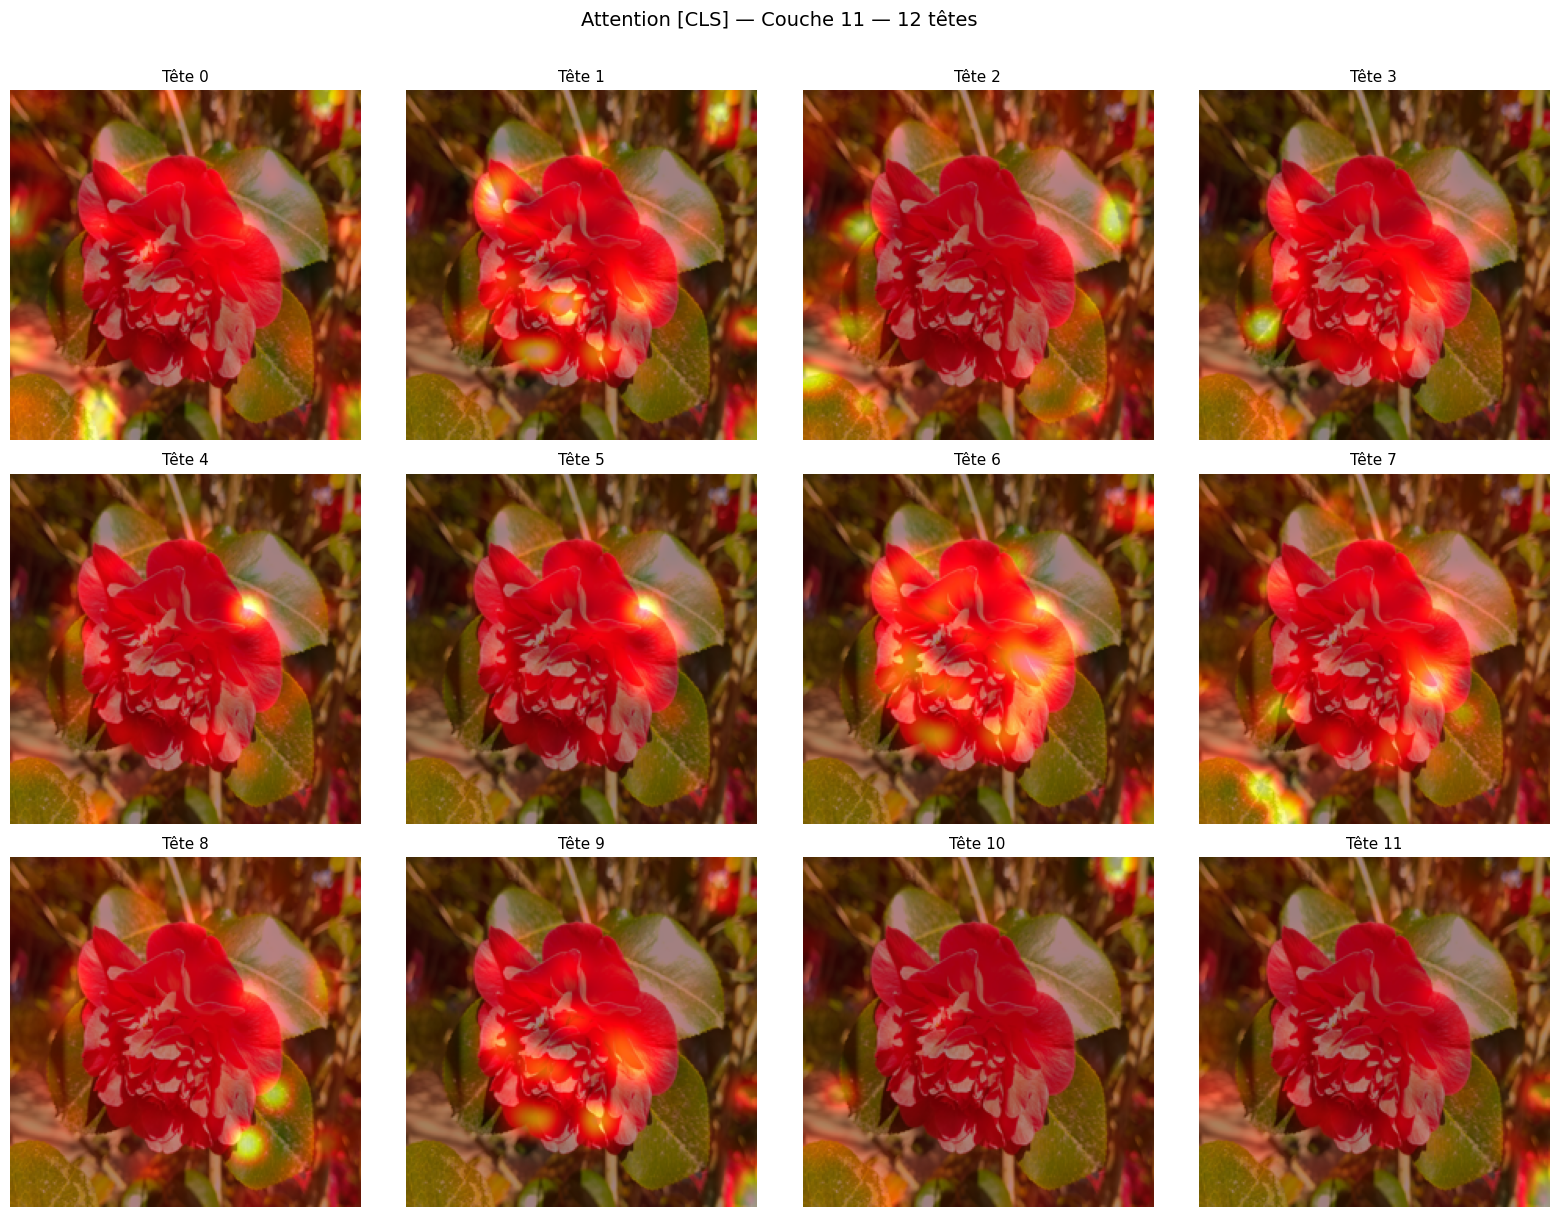

In [15]:
def visualize_all_heads(attentions, img_pil, layer_idx=-1):
    """Affiche l'attention du CLS pour chaque t\u00eate d'une couche donn\u00e9e."""
    attn = attentions[layer_idx][0]  # (heads, T, T)
    num_heads = attn.shape[0]
    img_np = np.array(img_pil.resize((224, 224))) / 255.0
    
    cols = 4
    rows = (num_heads + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    
    layer_num = layer_idx if layer_idx >= 0 else len(attentions) + layer_idx
    
    for h in range(num_heads):
        row, col = h // cols, h % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        cls_attn = attn[h, 0, 1:]  # attention CLS -> patches
        grid_size = int(cls_attn.shape[0] ** 0.5)
        attn_map = cls_attn.reshape(grid_size, grid_size).numpy()
        attn_resized = cv2.resize(attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
        attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)
        
        ax.imshow(img_np)
        ax.imshow(attn_resized, cmap='hot', alpha=0.5)
        ax.set_title(f'T\u00eate {h}', fontsize=11)
        ax.axis('off')
    
    plt.suptitle(f'Attention [CLS] \u2014 Couche {layer_num} \u2014 12 t\u00eates', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()

# Derni\u00e8re couche
visualize_all_heads(attentions, img_pil, layer_idx=-1)

### 5.2 Attention Rollout

L’attention d’une seule couche ne montre qu’une étape. Pour voir l’attention **cumulée**
à travers toutes les couches, on utilise l’**Attention Rollout** :

On multiplie les matrices d’attention couche par couche en ajoutant l’identité
(pour tenir compte des skip connections).

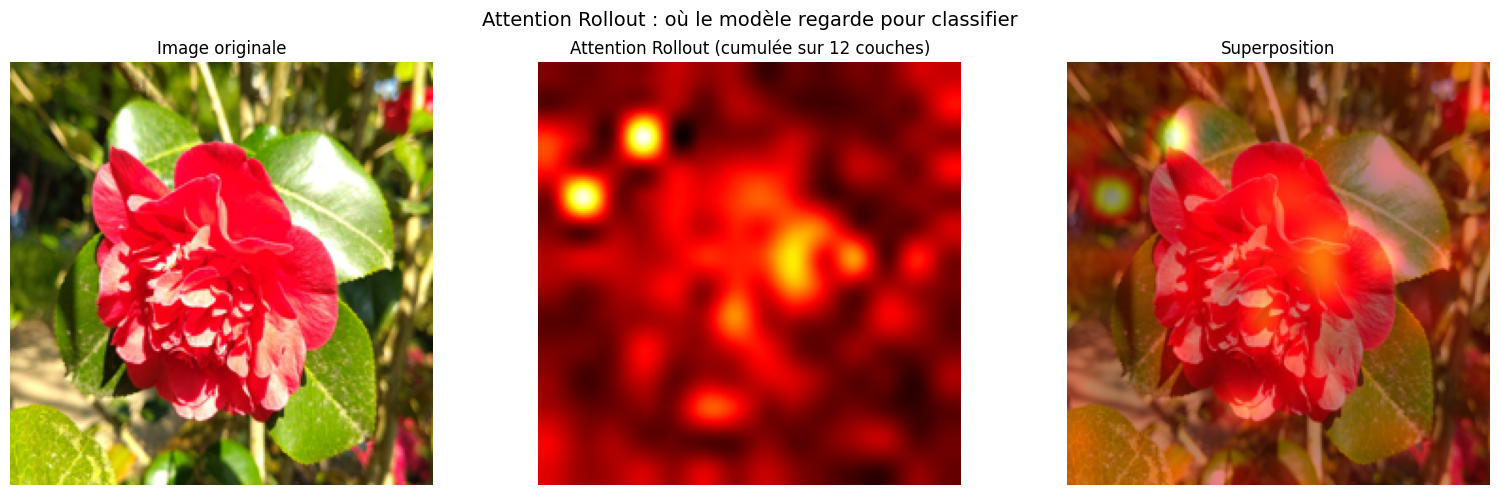

In [16]:
def attention_rollout(attentions, head_fusion='mean'):
    """
    Calcule l'Attention Rollout \u00e0 travers toutes les couches.
    
    R\u00e9f: Abnar & Zuidema, 2020 - "Quantifying Attention Flow in Transformers"
    """
    result = torch.eye(attentions[0].shape[-1])  # identit\u00e9 (T, T)
    
    for attn in attentions:
        # Fusionner les t\u00eates
        if head_fusion == 'mean':
            attn_fused = attn[0].mean(dim=0)  # (T, T)
        elif head_fusion == 'max':
            attn_fused = attn[0].max(dim=0)[0]
        elif head_fusion == 'min':
            attn_fused = attn[0].min(dim=0)[0]
        else:
            raise ValueError(f'head_fusion inconnu: {head_fusion}')
        
        # Ajouter l'identit\u00e9 (skip connection) et renormaliser
        I = torch.eye(attn_fused.shape[0])
        attn_with_residual = (attn_fused + I) / 2
        attn_with_residual = attn_with_residual / attn_with_residual.sum(dim=-1, keepdim=True)
        
        result = attn_with_residual @ result
    
    return result

rollout = attention_rollout(attentions)
cls_rollout = rollout[0, 1:]  # CLS -> patches

grid_size = int(cls_rollout.shape[0] ** 0.5)
rollout_map = cls_rollout.reshape(grid_size, grid_size).numpy()
rollout_resized = cv2.resize(rollout_map, (224, 224), interpolation=cv2.INTER_CUBIC)
rollout_resized = (rollout_resized - rollout_resized.min()) / (rollout_resized.max() - rollout_resized.min())

img_np = np.array(img_pil.resize((224, 224))) / 255.0

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(img_np)
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(rollout_resized, cmap='hot')
axes[1].set_title('Attention Rollout (cumul\u00e9e sur 12 couches)')
axes[1].axis('off')

axes[2].imshow(img_np)
axes[2].imshow(rollout_resized, cmap='hot', alpha=0.5)
axes[2].set_title('Superposition')
axes[2].axis('off')

plt.suptitle('Attention Rollout : o\u00f9 le mod\u00e8le regarde pour classifier', fontsize=14)
plt.tight_layout()
plt.show()

### 5.3 Attention entre patches (pas seulement CLS)

On peut aussi visualiser **l’attention d’un patch spécifique** vers tous les autres.
Cela montre quels patches sont "liés" entre eux selon le modèle.

In [ ]:
def visualize_patch_attention(attentions, img_pil, patch_idx, layer_idx=-1):
    """
    Visualise l'attention d'un patch sp\u00e9cifique vers tous les autres.
    
    Args:
        patch_idx: indice du patch (0-195). Le token CLS est \u00e0 l'indice 0 dans la matrice,
                   donc patch_idx=0 correspond au token 1 dans la matrice d'attention.
    """
    attn = attentions[layer_idx][0]  # (heads, T, T)
    token_idx = patch_idx + 1  # +1 car le CLS est \u00e0 l'indice 0
    
    # Moyenne sur les t\u00eates
    patch_attn = attn[:, token_idx, 1:].mean(dim=0)  # attention vers les patches (sans CLS)
    
    grid_size = int(patch_attn.shape[0] ** 0.5)
    attn_map = patch_attn.reshape(grid_size, grid_size).numpy()
    attn_resized = cv2.resize(attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)
    
    img_np = np.array(img_pil.resize((224, 224))) / 255.0
    
    # Position du patch source
    row = patch_idx // grid_size
    col = patch_idx % grid_size
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Image avec le patch source marqu\u00e9
    axes[0].imshow(img_np)
    rect = plt.Rectangle((col * 16, row * 16), 16, 16, linewidth=3, edgecolor='lime', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title(f'Patch source #{patch_idx} (vert)', fontsize=12)
    axes[0].axis('off')
    
    # Carte d'attention
    layer_num = layer_idx if layer_idx >= 0 else len(attentions) + layer_idx
    axes[1].imshow(attn_resized, cmap='hot')
    axes[1].set_title(f'Attention du patch {patch_idx} (couche {layer_num})', fontsize=12)
    axes[1].axis('off')
    
    # Superposition
    axes[2].imshow(img_np)
    axes[2].imshow(attn_resized, cmap='hot', alpha=0.5)
    rect2 = plt.Rectangle((col * 16, row * 16), 16, 16, linewidth=3, edgecolor='lime', facecolor='none')
    axes[2].add_patch(rect2)
    axes[2].set_title('Superposition', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Patch au centre de l'image (indice 98 sur une grille 14x14)
visualize_patch_attention(attentions, img_pil, patch_idx=98, layer_idx=-1)

# Patch en haut \u00e0 gauche
visualize_patch_attention(attentions, img_pil, patch_idx=0, layer_idx=-1)

## 6. Visualisation des Position Embeddings

Les position embeddings sont des vecteurs appris qui encodent la **position spatiale**
de chaque patch. On peut visualiser leur **similarité** pour vérifier qu’ils capturent
bien la structure 2D de l’image.

In [ ]:
def visualize_position_embeddings(model):
    """Visualise la similarit\u00e9 cosinus entre les position embeddings."""
    pos_embed = model.pos_embed[0, 1:, :].detach().cpu()  # (196, D) sans le CLS
    
    # Similarit\u00e9 cosinus entre tous les patches
    pos_norm = F.normalize(pos_embed, dim=-1)
    sim_matrix = pos_norm @ pos_norm.T  # (196, 196)
    
    grid_size = int(pos_embed.shape[0] ** 0.5)  # 14
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    
    # Choisir quelques patches de r\u00e9f\u00e9rence
    ref_patches = [
        (0, 'Haut-gauche (0,0)'),
        (6, 'Haut-centre (0,6)'),
        (13, 'Haut-droite (0,13)'),
        (91, 'Centre-gauche (6,7)'),
        (98, 'Centre (7,0)'),
        (105, 'Centre-droite (7,7)'),
        (182, 'Bas-gauche (13,0)'),
        (195, 'Bas-droite (13,13)'),
    ]
    
    for idx, (patch_idx, label) in enumerate(ref_patches):
        row, col = idx // 4, idx % 4
        ax = axes[row, col]
        
        sim = sim_matrix[patch_idx].reshape(grid_size, grid_size).numpy()
        im = ax.imshow(sim, cmap='RdYlBu_r', vmin=-0.5, vmax=1.0)
        
        # Marquer le patch de r\u00e9f\u00e9rence
        ref_row, ref_col = patch_idx // grid_size, patch_idx % grid_size
        ax.plot(ref_col, ref_row, 'k*', markersize=12)
        
        ax.set_title(label, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle('Similarit\u00e9 cosinus des Position Embeddings\n(\u2605 = patch de r\u00e9f\u00e9rence, rouge = similaire, bleu = diff\u00e9rent)',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_position_embeddings(model)

## 7. Exercices

### Exercice 1 — Tester sur une autre image

Chargez une image de votre choix (URL ou fichier local) et :
1. Classifiez-la avec le ViT.
2. Visualisez l’attention du CLS sur la dernière couche.
3. L’attention se concentre-t-elle sur l’objet principal ?

### Exercice 2 — Comparer les têtes

Pour la couche 6 (milieu du réseau) :
1. Affichez les 12 têtes avec `visualize_all_heads(attentions, img_pil, layer_idx=6)`.
2. Identifiez une tête qui semble capturer les contours et une qui capture le contexte global.

### Exercice 3 — Attention Rollout vs dernière couche

1. Comparez visuellement l’Attention Rollout avec l’attention de la dernière couche seule.
2. Laquelle donne une meilleure localisation de l’objet ? Pourquoi ?

### Exercice 4 — Attention entre patches

1. Choisissez un patch sur l’objet principal et un patch sur le fond.
2. Visualisez leur attention respective avec `visualize_patch_attention`.
3. Les patches de l’objet s’attendent-ils mutuellement ? Et ceux du fond ?

### Exercice 5 — Impact de la couche

1. Pour un même patch, comparez son attention aux couches 0, 3, 6, 9, 11.
2. Comment l’attention évolue-t-elle de locale à globale ?

In [ ]:
# Espace pour les exercices

# Exercice 1 : Tester sur une autre image
# url_custom = 'https://...'
# response = requests.get(url_custom)
# img_custom = Image.open(BytesIO(response.content)).convert('RGB')
# img_tensor_custom = transform(img_custom).unsqueeze(0).to(device)
# attentions_custom = extract_attentions(model, img_tensor_custom)
# visualize_cls_attention(attentions_custom, img_custom)

# Exercice 2 : Comparer les t\u00eates de la couche 6
# visualize_all_heads(attentions, img_pil, layer_idx=6)

# Exercice 3 : Rollout vs derni\u00e8re couche
# (d\u00e9j\u00e0 fait ci-dessus, comparer visuellement)

# Exercice 4 : Attention entre patches
# visualize_patch_attention(attentions, img_pil, patch_idx=???, layer_idx=-1)

# Exercice 5 : Impact de la couche
# for layer in [0, 3, 6, 9, 11]:
#     visualize_patch_attention(attentions, img_pil, patch_idx=98, layer_idx=layer)